In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()

            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()

                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "bncnn_model.pth")
    print("Model saved to bncnn_model.pth")

    channels, height, width = 1, 50, 50
    # Print model summary
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    # print(summary_str)

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)

    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")


    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    return {
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'all_predictions': all_predictions,
        'all_targets': all_targets,
        'all_val_predictions': all_val_predictions,
        'all_val_targets': all_val_targets
    }

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:37<00:00, 36.44it/s]


Epoch 1/100, Train Loss: -0.107138, Train Acc: 0.1323, Val Loss: -0.327044, Val Acc: 0.1605


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:23<00:00, 49.78it/s]


Epoch 2/100, Train Loss: -0.449786, Train Acc: 0.1994, Val Loss: -0.592301, Val Acc: 0.2224


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:07<00:00, 53.88it/s]


Epoch 3/100, Train Loss: -0.925491, Train Acc: 0.2852, Val Loss: -0.943374, Val Acc: 0.2879


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:05<00:00, 54.67it/s]


Epoch 4/100, Train Loss: -1.346241, Train Acc: 0.3491, Val Loss: -1.195342, Val Acc: 0.3286


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:29<00:00, 48.22it/s]


Epoch 5/100, Train Loss: -1.618120, Train Acc: 0.3859, Val Loss: -1.305116, Val Acc: 0.3515


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:15<00:00, 51.88it/s]


Epoch 6/100, Train Loss: -1.793419, Train Acc: 0.4101, Val Loss: -1.429604, Val Acc: 0.3604


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:10<00:00, 53.18it/s]


Epoch 7/100, Train Loss: -1.913824, Train Acc: 0.4227, Val Loss: -1.562923, Val Acc: 0.3765


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:44<00:00, 45.11it/s]


Epoch 8/100, Train Loss: -2.005954, Train Acc: 0.4342, Val Loss: -1.682386, Val Acc: 0.3853


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:13<00:00, 52.28it/s]


Epoch 9/100, Train Loss: -2.084998, Train Acc: 0.4445, Val Loss: -1.667476, Val Acc: 0.3932


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:19<00:00, 50.81it/s]


Epoch 10/100, Train Loss: -2.139467, Train Acc: 0.4489, Val Loss: -1.796742, Val Acc: 0.3998


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:03<00:00, 55.17it/s]


Epoch 11/100, Train Loss: -2.191844, Train Acc: 0.4565, Val Loss: -1.776296, Val Acc: 0.4066


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:06<00:00, 54.15it/s]


Epoch 12/100, Train Loss: -2.237147, Train Acc: 0.4612, Val Loss: -1.847636, Val Acc: 0.4097


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:31<00:00, 47.95it/s]


Epoch 13/100, Train Loss: -2.275408, Train Acc: 0.4657, Val Loss: -1.895759, Val Acc: 0.4100


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:21<00:00, 50.18it/s]


Epoch 14/100, Train Loss: -2.312703, Train Acc: 0.4704, Val Loss: -1.932356, Val Acc: 0.4173


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.89it/s]


Epoch 15/100, Train Loss: -2.337925, Train Acc: 0.4736, Val Loss: -1.988939, Val Acc: 0.4173


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:16<00:00, 51.60it/s]


Epoch 16/100, Train Loss: -2.365205, Train Acc: 0.4764, Val Loss: -1.882507, Val Acc: 0.4202


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:15<00:00, 51.80it/s]


Epoch 17/100, Train Loss: -2.394682, Train Acc: 0.4786, Val Loss: -1.968239, Val Acc: 0.4246


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:10<00:00, 53.19it/s]


Epoch 18/100, Train Loss: -2.417649, Train Acc: 0.4826, Val Loss: -2.031009, Val Acc: 0.4299


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:03<00:00, 55.16it/s]


Epoch 19/100, Train Loss: -2.438004, Train Acc: 0.4861, Val Loss: -1.946334, Val Acc: 0.4243


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 57.00it/s]


Epoch 20/100, Train Loss: -2.464904, Train Acc: 0.4866, Val Loss: -1.993610, Val Acc: 0.4312


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:56<00:00, 57.29it/s]


Epoch 21/100, Train Loss: -2.476934, Train Acc: 0.4890, Val Loss: -2.059693, Val Acc: 0.4302


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:17<00:00, 51.27it/s]


Epoch 22/100, Train Loss: -2.501225, Train Acc: 0.4925, Val Loss: -2.114050, Val Acc: 0.4362


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:59<00:00, 56.29it/s]


Epoch 23/100, Train Loss: -2.516176, Train Acc: 0.4927, Val Loss: -2.137141, Val Acc: 0.4359


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:06<00:00, 54.14it/s]


Epoch 24/100, Train Loss: -2.535564, Train Acc: 0.4968, Val Loss: -2.016202, Val Acc: 0.4380


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:04<00:00, 54.93it/s]


Epoch 25/100, Train Loss: -2.550355, Train Acc: 0.4963, Val Loss: -2.113860, Val Acc: 0.4415


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:47<00:00, 60.24it/s]


Epoch 26/100, Train Loss: -2.564730, Train Acc: 0.4988, Val Loss: -2.132690, Val Acc: 0.4423


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:38<00:00, 63.96it/s]


Epoch 27/100, Train Loss: -2.581117, Train Acc: 0.4999, Val Loss: -2.228630, Val Acc: 0.4500


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:38<00:00, 63.79it/s]


Epoch 28/100, Train Loss: -2.593953, Train Acc: 0.5017, Val Loss: -2.234312, Val Acc: 0.4430


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:41<00:00, 62.80it/s]


Epoch 29/100, Train Loss: -2.598301, Train Acc: 0.5030, Val Loss: -2.189231, Val Acc: 0.4502


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:47<00:00, 60.47it/s]


Epoch 30/100, Train Loss: -2.616388, Train Acc: 0.5048, Val Loss: -2.239948, Val Acc: 0.4451


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:55<00:00, 57.65it/s]


Epoch 31/100, Train Loss: -2.633690, Train Acc: 0.5061, Val Loss: -2.245762, Val Acc: 0.4449


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:56<00:00, 57.30it/s]


Epoch 32/100, Train Loss: -2.642737, Train Acc: 0.5066, Val Loss: -2.260486, Val Acc: 0.4482


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:00<00:00, 56.01it/s]


Epoch 33/100, Train Loss: -2.656480, Train Acc: 0.5093, Val Loss: -2.275700, Val Acc: 0.4505


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:48<00:00, 60.06it/s]


Epoch 34/100, Train Loss: -2.661865, Train Acc: 0.5096, Val Loss: -2.288909, Val Acc: 0.4501


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:51<00:00, 59.09it/s]


Epoch 35/100, Train Loss: -2.667377, Train Acc: 0.5104, Val Loss: -2.213027, Val Acc: 0.4457


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:11<00:00, 52.91it/s]


Epoch 36/100, Train Loss: -2.680218, Train Acc: 0.5129, Val Loss: -2.266586, Val Acc: 0.4463


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:55<00:00, 57.78it/s]


Epoch 37/100, Train Loss: -2.694767, Train Acc: 0.5150, Val Loss: -2.304700, Val Acc: 0.4530


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 56.91it/s]


Epoch 38/100, Train Loss: -2.706096, Train Acc: 0.5155, Val Loss: -2.294612, Val Acc: 0.4515


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 56.92it/s]


Epoch 39/100, Train Loss: -2.708178, Train Acc: 0.5168, Val Loss: -2.283800, Val Acc: 0.4531


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:01<00:00, 55.72it/s]


Epoch 40/100, Train Loss: -2.723780, Train Acc: 0.5171, Val Loss: -2.310246, Val Acc: 0.4546


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.82it/s]


Epoch 41/100, Train Loss: -2.727431, Train Acc: 0.5182, Val Loss: -2.385133, Val Acc: 0.4566


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:42<00:00, 62.16it/s]


Epoch 42/100, Train Loss: -2.731966, Train Acc: 0.5189, Val Loss: -2.352782, Val Acc: 0.4515


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:40<00:00, 62.93it/s]


Epoch 43/100, Train Loss: -2.738823, Train Acc: 0.5195, Val Loss: -2.289588, Val Acc: 0.4564


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:36<00:00, 64.61it/s]


Epoch 44/100, Train Loss: -2.749060, Train Acc: 0.5216, Val Loss: -2.396850, Val Acc: 0.4610


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.76it/s]


Epoch 45/100, Train Loss: -2.752450, Train Acc: 0.5218, Val Loss: -2.256822, Val Acc: 0.4568


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:05<00:00, 54.56it/s]


Epoch 46/100, Train Loss: -2.762650, Train Acc: 0.5241, Val Loss: -2.358011, Val Acc: 0.4586


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:06<00:00, 54.36it/s]


Epoch 47/100, Train Loss: -2.762493, Train Acc: 0.5221, Val Loss: -2.359310, Val Acc: 0.4626


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:44<00:00, 61.41it/s]


Epoch 48/100, Train Loss: -2.775652, Train Acc: 0.5251, Val Loss: -2.359099, Val Acc: 0.4590


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:44<00:00, 61.45it/s]


Epoch 49/100, Train Loss: -2.780496, Train Acc: 0.5257, Val Loss: -2.440155, Val Acc: 0.4625


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:52<00:00, 58.63it/s]


Epoch 50/100, Train Loss: -2.775725, Train Acc: 0.5250, Val Loss: -2.391665, Val Acc: 0.4611


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:43<00:00, 62.01it/s]


Epoch 51/100, Train Loss: -2.793842, Train Acc: 0.5269, Val Loss: -2.441684, Val Acc: 0.4616


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:02<00:00, 55.47it/s]


Epoch 52/100, Train Loss: -2.802372, Train Acc: 0.5266, Val Loss: -2.274342, Val Acc: 0.4606


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:51<00:00, 59.01it/s]


Epoch 53/100, Train Loss: -2.802212, Train Acc: 0.5281, Val Loss: -2.412751, Val Acc: 0.4618


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:04<00:00, 54.99it/s]


Epoch 54/100, Train Loss: -2.804719, Train Acc: 0.5280, Val Loss: -2.422768, Val Acc: 0.4667


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:08<00:00, 53.66it/s]


Epoch 55/100, Train Loss: -2.811767, Train Acc: 0.5278, Val Loss: -2.435446, Val Acc: 0.4645


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:22<00:00, 49.99it/s]


Epoch 56/100, Train Loss: -2.815728, Train Acc: 0.5307, Val Loss: -2.455969, Val Acc: 0.4672


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:56<00:00, 57.21it/s]


Epoch 57/100, Train Loss: -2.818006, Train Acc: 0.5305, Val Loss: -2.449732, Val Acc: 0.4611


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:45<00:00, 60.97it/s]


Epoch 58/100, Train Loss: -2.823966, Train Acc: 0.5306, Val Loss: -2.449558, Val Acc: 0.4674


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:52<00:00, 58.75it/s]


Epoch 59/100, Train Loss: -2.832965, Train Acc: 0.5325, Val Loss: -2.511768, Val Acc: 0.4732


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 56.87it/s]


Epoch 60/100, Train Loss: -2.836259, Train Acc: 0.5324, Val Loss: -2.392771, Val Acc: 0.4652


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:06<00:00, 54.35it/s]


Epoch 61/100, Train Loss: -2.842661, Train Acc: 0.5319, Val Loss: -2.516097, Val Acc: 0.4749


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:55<00:00, 57.77it/s]


Epoch 62/100, Train Loss: -2.840905, Train Acc: 0.5335, Val Loss: -2.510494, Val Acc: 0.4735


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:41<00:00, 62.48it/s]


Epoch 63/100, Train Loss: -2.842643, Train Acc: 0.5328, Val Loss: -2.460164, Val Acc: 0.4683


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:47<00:00, 60.56it/s]


Epoch 64/100, Train Loss: -2.847669, Train Acc: 0.5341, Val Loss: -2.431676, Val Acc: 0.4668


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:49<00:00, 59.64it/s]


Epoch 65/100, Train Loss: -2.854725, Train Acc: 0.5338, Val Loss: -2.468562, Val Acc: 0.4692


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:49<00:00, 59.84it/s]


Epoch 66/100, Train Loss: -2.855995, Train Acc: 0.5343, Val Loss: -2.519494, Val Acc: 0.4707


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:37<00:00, 64.34it/s]


Epoch 67/100, Train Loss: -2.853766, Train Acc: 0.5340, Val Loss: -2.412356, Val Acc: 0.4684


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:07<00:00, 53.86it/s]


Epoch 68/100, Train Loss: -2.858692, Train Acc: 0.5344, Val Loss: -2.533001, Val Acc: 0.4723


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:03<00:00, 55.02it/s]


Epoch 69/100, Train Loss: -2.866419, Train Acc: 0.5361, Val Loss: -2.466035, Val Acc: 0.4707


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:49<00:00, 59.82it/s]


Epoch 70/100, Train Loss: -2.872530, Train Acc: 0.5379, Val Loss: -2.511496, Val Acc: 0.4711


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:50<00:00, 59.22it/s]


Epoch 71/100, Train Loss: -2.875476, Train Acc: 0.5387, Val Loss: -2.531695, Val Acc: 0.4708


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.71it/s]


Epoch 72/100, Train Loss: -2.874270, Train Acc: 0.5371, Val Loss: -2.520003, Val Acc: 0.4693


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:45<00:00, 61.06it/s]


Epoch 73/100, Train Loss: -2.876695, Train Acc: 0.5373, Val Loss: -2.526072, Val Acc: 0.4724


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:51<00:00, 59.10it/s]


Epoch 74/100, Train Loss: -2.887856, Train Acc: 0.5395, Val Loss: -2.538223, Val Acc: 0.4729


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:24<00:00, 49.50it/s]


Epoch 75/100, Train Loss: -2.885719, Train Acc: 0.5382, Val Loss: -2.492642, Val Acc: 0.4653


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:16<00:00, 51.51it/s]


Epoch 76/100, Train Loss: -2.892340, Train Acc: 0.5390, Val Loss: -2.532670, Val Acc: 0.4706


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:50<00:00, 59.22it/s]


Epoch 77/100, Train Loss: -2.897255, Train Acc: 0.5390, Val Loss: -2.532282, Val Acc: 0.4729


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:52<00:00, 58.76it/s]


Epoch 78/100, Train Loss: -2.894748, Train Acc: 0.5394, Val Loss: -2.533466, Val Acc: 0.4696


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:11<00:00, 52.93it/s]


Epoch 79/100, Train Loss: -2.890719, Train Acc: 0.5392, Val Loss: -2.511014, Val Acc: 0.4708


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:54<00:00, 58.13it/s]


Epoch 80/100, Train Loss: -2.900478, Train Acc: 0.5395, Val Loss: -2.543958, Val Acc: 0.4702


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:55<00:00, 57.56it/s]


Epoch 81/100, Train Loss: -2.902866, Train Acc: 0.5398, Val Loss: -2.555732, Val Acc: 0.4742


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 57.14it/s]


Epoch 82/100, Train Loss: -2.901967, Train Acc: 0.5402, Val Loss: -2.535841, Val Acc: 0.4733


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:07<00:00, 54.12it/s]


Epoch 83/100, Train Loss: -2.909158, Train Acc: 0.5420, Val Loss: -2.590697, Val Acc: 0.4740


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:08<00:00, 53.69it/s]


Epoch 84/100, Train Loss: -2.906567, Train Acc: 0.5410, Val Loss: -2.530756, Val Acc: 0.4737


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:54<00:00, 57.97it/s]


Epoch 85/100, Train Loss: -2.913523, Train Acc: 0.5414, Val Loss: -2.540008, Val Acc: 0.4762


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.69it/s]


Epoch 86/100, Train Loss: -2.915104, Train Acc: 0.5430, Val Loss: -2.548266, Val Acc: 0.4739


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:50<00:00, 59.48it/s]


Epoch 87/100, Train Loss: -2.916032, Train Acc: 0.5420, Val Loss: -2.582284, Val Acc: 0.4778


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:48<00:00, 60.00it/s]


Epoch 88/100, Train Loss: -2.916755, Train Acc: 0.5419, Val Loss: -2.545035, Val Acc: 0.4710


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:57<00:00, 57.13it/s]


Epoch 89/100, Train Loss: -2.924203, Train Acc: 0.5430, Val Loss: -2.536320, Val Acc: 0.4698


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:15<00:00, 51.78it/s]


Epoch 90/100, Train Loss: -2.923722, Train Acc: 0.5432, Val Loss: -2.607421, Val Acc: 0.4820


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:51<00:00, 58.97it/s]


Epoch 91/100, Train Loss: -2.927198, Train Acc: 0.5437, Val Loss: -2.567134, Val Acc: 0.4761


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:54<00:00, 57.83it/s]


Epoch 92/100, Train Loss: -2.928973, Train Acc: 0.5449, Val Loss: -2.588986, Val Acc: 0.4769


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:54<00:00, 58.02it/s]


Epoch 93/100, Train Loss: -2.927831, Train Acc: 0.5446, Val Loss: -2.583051, Val Acc: 0.4801


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:01<00:00, 55.82it/s]


Epoch 94/100, Train Loss: -2.936150, Train Acc: 0.5443, Val Loss: -2.613168, Val Acc: 0.4799


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:52<00:00, 58.75it/s]


Epoch 95/100, Train Loss: -2.940108, Train Acc: 0.5436, Val Loss: -2.585734, Val Acc: 0.4806


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:46<00:00, 60.94it/s]


Epoch 96/100, Train Loss: -2.936033, Train Acc: 0.5437, Val Loss: -2.527676, Val Acc: 0.4827


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [02:44<00:00, 61.62it/s]


Epoch 97/100, Train Loss: -2.938797, Train Acc: 0.5454, Val Loss: -2.597724, Val Acc: 0.4713


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:04<00:00, 54.96it/s]


Epoch 98/100, Train Loss: -2.940288, Train Acc: 0.5453, Val Loss: -2.594102, Val Acc: 0.4808


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:00<00:00, 56.04it/s]


Epoch 99/100, Train Loss: -2.937400, Train Acc: 0.5469, Val Loss: -2.581473, Val Acc: 0.4786


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 10120/10120 [02:41<00:00, 62.55it/s]


Epoch 100/100, Train Loss: -2.946017, Train Acc: 0.5452, Val Loss: -2.571435, Val Acc: 0.4813
Model saved to bncnn_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
BNCNN                                    [32, 9]                   --
├─Sequential: 1-1                        [32, 9]                   --
│    └─0.weight                                                    ├─800
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      ├─32
│    └─4.weight                                                    ├─51,200
│    └─5.weight                                                    ├─64
│    └─5.bias                                                      ├─64
│    └─9.weight                                                    ├─1,016,064
│    └─10.weight                                                   ├─9
│    └─10.bias                                                     └─9
│ 

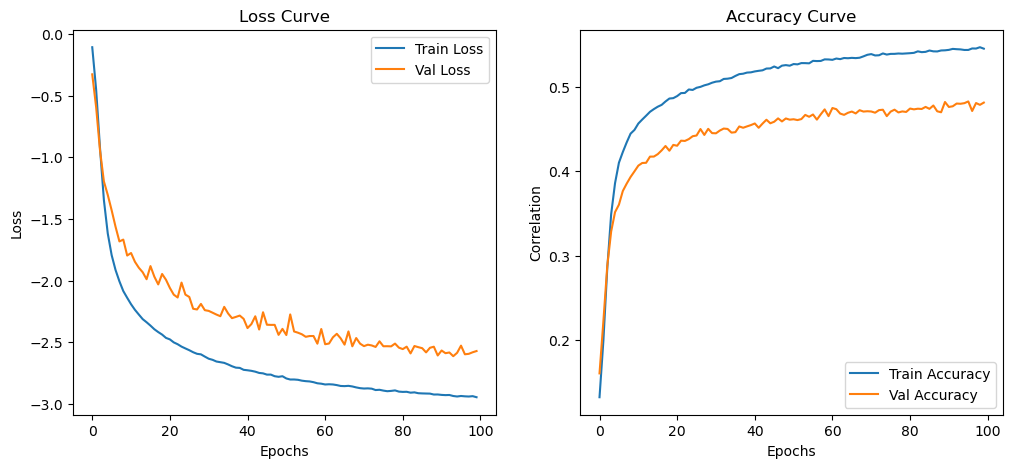

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
results = train_model(h5_path, hyperparams)

In [12]:
def plot_neuron_predictions(results, start=0, end=40):
    if end is None:
        end = results['all_targets'].shape[0]  # Full length if not specified

    # Plot True vs. Predicted for 9 neurons (training data)
    print(f"\nPlotting training data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Training)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot for validation data
    print(f"\nPlotting validation data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_val_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_val_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Validation)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


In [13]:
import json

def save_training_results(results, filename="training_results.json"):
    # Create a copy to avoid modifying the original
    results_to_save = results.copy()
    
    # Remove the model (can't be JSON-serialized)
    model = results_to_save.pop('model')  # Save separately with torch.save
    
    # Convert numpy arrays to lists
    for key, value in results_to_save.items():
        if isinstance(value, np.ndarray):
            results_to_save[key] = value.tolist()
    
    # Save to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results_to_save, f, indent=4)  # indent=4 for readability
    
    print(f"Results saved to {filename} (excluding model)")

# Example usage after training:
save_training_results(results)

NameError: name 'results' is not defined

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_training_results(filename="training_results.json"):
    """Load training results from JSON file and convert lists back to numpy arrays"""
    with open(filename, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convert lists back to numpy arrays for the prediction/target data
    array_keys = ['all_predictions', 'all_targets', 'all_val_predictions', 'all_val_targets']
    for key in array_keys:
        if key in results:
            results[key] = np.array(results[key])
    
    return results


Plotting training data predictions from 0 to 40:


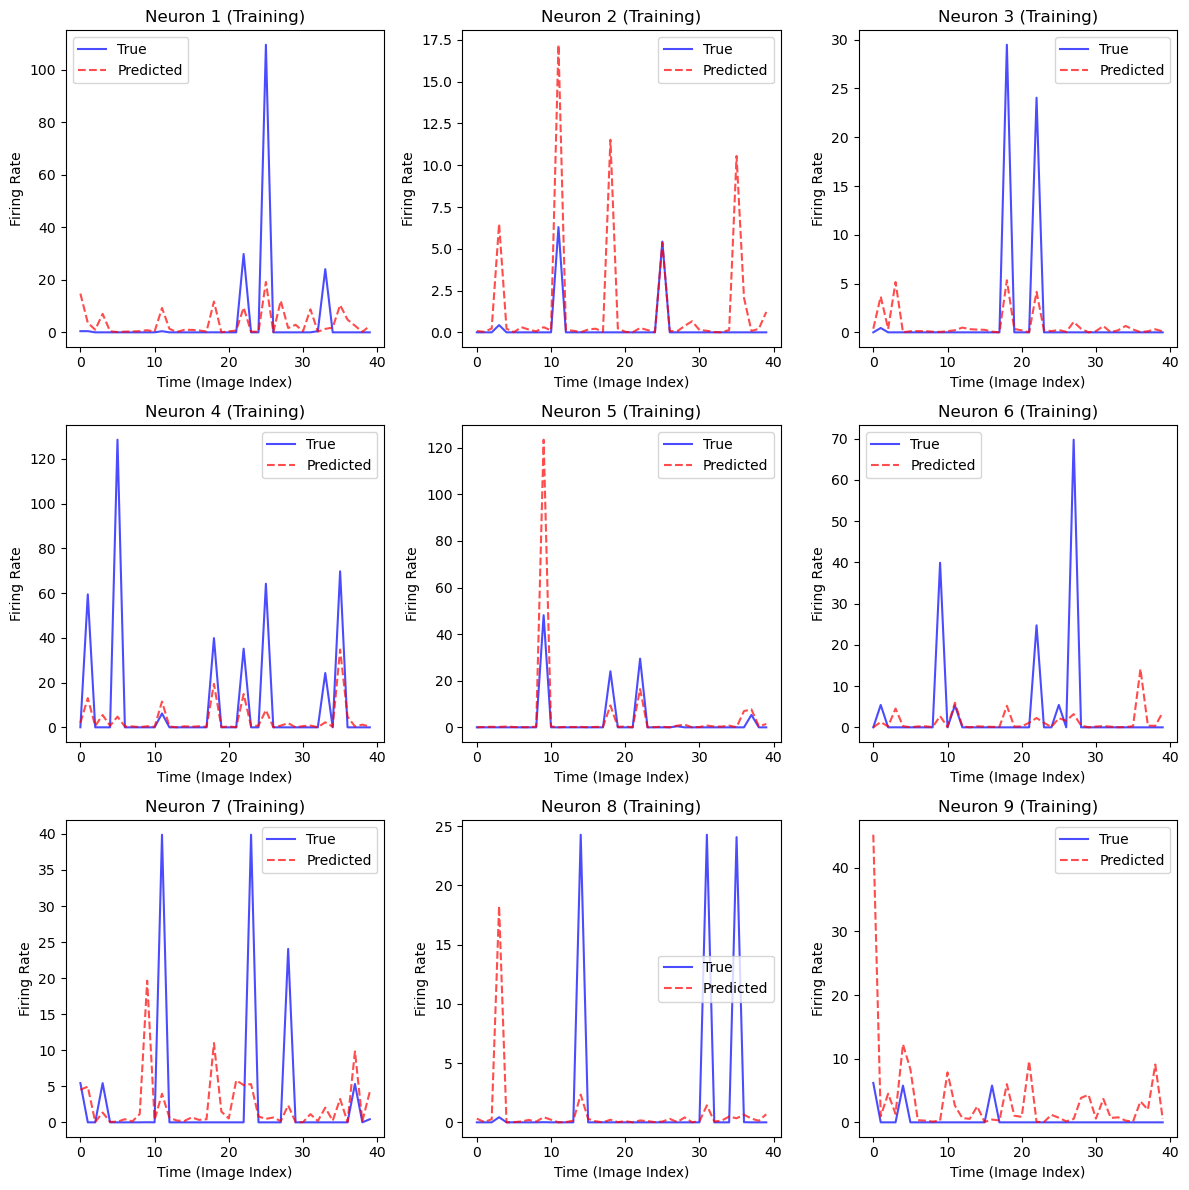


Plotting validation data predictions from 0 to 40:


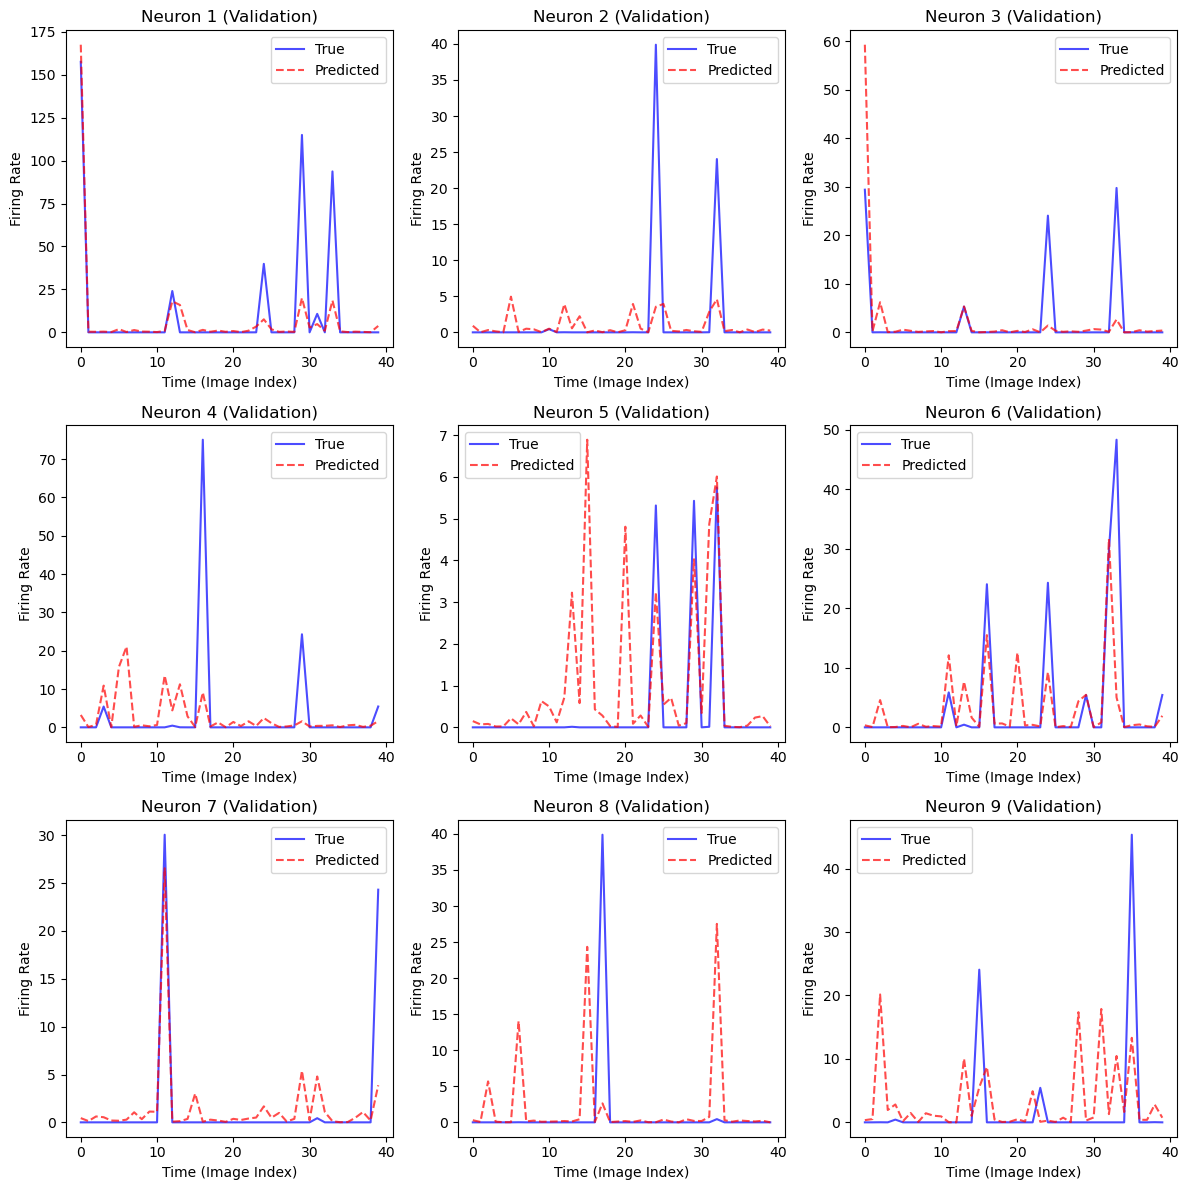

In [15]:
# Load the saved results
loaded_results = load_training_results("training_results.json")

# Pass to your plotting function
plot_neuron_predictions(loaded_results)